# Topic Classification
---

The objective of this task is to perform document topic analysis using a dataset of English-language news articles to classify them into five distinct categories using a supervised learning model. 

To achieve this, a multi-class classifier is built to predict the category to which a given document belongs. The model is trained on a labeled dataset where each document is associated with one of the five predefined topics.

The performance of the model is evaluated using cross-validation results and an independent test set. This approach allows us to assess the model’s generalization ability and its effectiveness in accurately classifying unseen documents.

In [ ]:
import pandas as pd
import numpy as np

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, AdamW, get_scheduler
from datasets import Dataset, DatasetDict

import matplotlib.pyplot as plt

import os
import zipfile
from tqdm.auto import tqdm

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

Device count: 1
Current device: 0
NVIDIA GeForce RTX 3090


## Exploratory Data Analysis (EDA)

### Dataset

For this practice, a dataset derived from the "BBC Full Text Document Classification" has been used. The dataset consists of 2225 news articles sourced from the BBC News website, covering the years 2004 and 2005. Each document is categorized into one of five predefined classes: 
- Business.
- Entertainment.
- Politics.
- Sport.
- Tech.

From the dataset, a total of 2015 articles have been used for training and the remaining 210 articles for test.

In [ ]:
data_path = "./data/"
train_zip = data_path + "bbc-train.zip"
test_zip = data_path + "bbc-test.zip"

train_path = data_path + "bbc-train"
test_path= data_path + "bbc-test"

In [4]:
# Reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Unzip data files
if not os.path.exists(train_path):
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Unzipped train data")

if not os.path.exists(test_path):
    with zipfile.ZipFile(test_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Unzipped test data")

### Train data

In [6]:
class_names = sorted(x for x in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, x)))
num_class = len(class_names)
train_files = [
    [os.path.join(train_path, class_names[i], x) for x in os.listdir(os.path.join(train_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(train_files[i]) for i in range(num_class)]
train_files_list = []
train_classes = []
for i in range(num_class):
    train_files_list.extend(train_files[i])
    train_classes.extend([i] * num_each[i])
num_total = len(train_classes)

print(f"Number of train documents: {num_total}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Number of train documents: 2015
Label names: ['business', 'entertainment', 'politics', 'sports', 'tech']
Label counts: [460, 356, 377, 461, 361]


### Test data

In [7]:
test_files = [
    [os.path.join(test_path, class_names[i], x) for x in os.listdir(os.path.join(test_path, class_names[i]))]
    for i in range(num_class)
]
num_each = [len(test_files[i]) for i in range(num_class)]
test_files_list = []
test_classes = []
for i in range(num_class):
    test_files_list.extend(test_files[i])
    test_classes.extend([i] * num_each[i])
num_total = len(test_classes)

print(f"Number of test documents: {num_total}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Number of test documents: 210
Label names: ['business', 'entertainment', 'politics', 'sports', 'tech']
Label counts: [50, 30, 40, 50, 40]


Train data: 90.56%
Test data: 9.44%


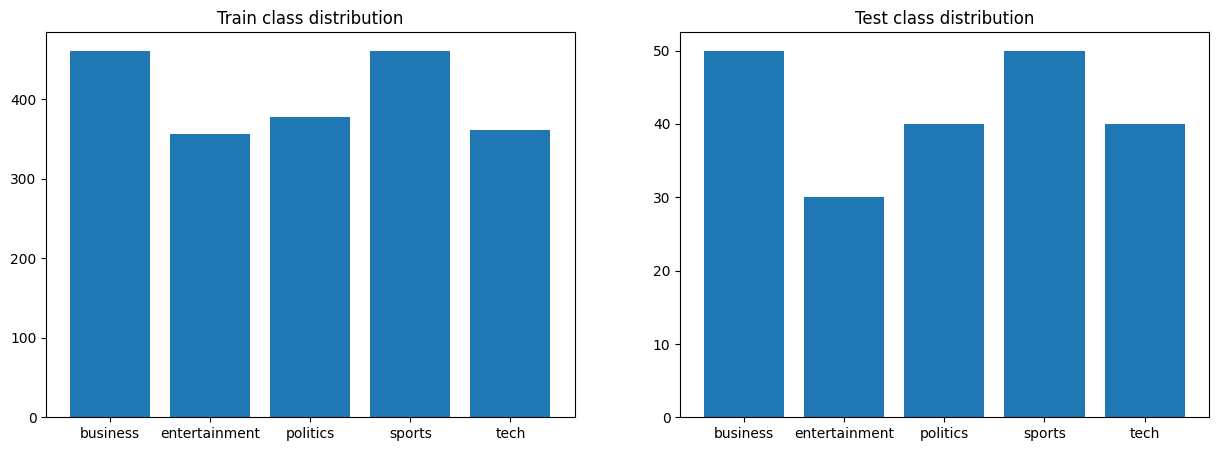

In [8]:
# Percentage of test and train data
train_percent = len(train_files_list) / (len(train_files_list) + len(test_files_list))
test_percent = len(test_files_list) / (len(train_files_list) + len(test_files_list))
print(f"Train data: {train_percent * 100:.2f}%")
print(f"Test data: {test_percent * 100:.2f}%")

# Plot class distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(class_names, [len(train_files[i]) for i in range(num_class)])
plt.title("Train class distribution")
plt.subplot(1, 2, 2)
plt.bar(class_names, [len(test_files[i]) for i in range(num_class)])
plt.title("Test class distribution")
plt.show()

As it can be seen, the dataset is a bit unbalanced when it comes to the number of articles per class, with the business class having the most samples and the entertainment the fewest. Nonetheless, the difference is not significant and does not affect the results of the model.

In [9]:
# Read example train file
print("File name:", train_files_list[0])
print()
with open(train_files_list[0], "r") as f:
    print(f.read())

File name: ./data/bbc-train/business/461.txt

Beijingers fume over parking fees

Choking traffic jams in Beijing are prompting officials to look at reorganising car parking charges.

Car ownership has risen fast in recent years, and there are now two and a half million cars on the city's roads. The trouble is that the high status of car ownership is matched by expensive fees at indoor car parks, making motorists reluctant to use them. Instead roads are being clogged by drivers circling in search of a cheaper outdoor option. "The price differences between indoor and outdoor lots are unreasonable," said Wang Yan, an official from the Beijing Municipal Commission for Development and Reform quoted in the state-run China Daily newspaper. Mr Wang, who is in charge of collecting car parking fees, said his team would be looking at adjusting parking prices to close the gap. Indoor parking bays can cost up to 250% more than outdoor ones.

Sports fans who drive to matches may also find themselves

As observed in the example article above, each file in the dataset follows a consistent structure. The first row contains a header, typically representing the article's title, while the remaining lines form the main body of the text. 

### Create Datasets

In [10]:
train_texts = []
train_labels = []
train_ids = []
for file in train_files_list:
    with open(file, "r") as f:
        try:
            text = f.read()
            train_texts.append(text)
            label = file.split("/")[-2]
            train_labels.append(class_names.index(label))
            train_ids.append(file.split("/")[-1])
        except:
            print("Error reading file:", file)

test_texts = []
test_labels = []
test_ids = []
for file in test_files_list:
    with open(file, "r") as f:
        try:
            text = f.read()
            test_texts.append(text)
            label = file.split("/")[-2]
            test_labels.append(class_names.index(label))
            test_ids.append(file.split("/")[-1])
        except:
            print("Error reading file:", file)

train_df = pd.DataFrame({"id": train_ids, "text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"id": test_ids, "text": test_texts, "label": test_labels})

Error reading file: ./data/bbc-train/sports/199.txt


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2014 entries, 0 to 2013
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2014 non-null   object
 1   text    2014 non-null   object
 2   label   2014 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 47.3+ KB


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      210 non-null    object
 1   text    210 non-null    object
 2   label   210 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 5.0+ KB


In [13]:
train_df["label"].value_counts()

label
0    460
3    460
2    377
4    361
1    356
Name: count, dtype: int64

In [14]:
test_df["label"].value_counts()

label
0    50
3    50
2    40
4    40
1    30
Name: count, dtype: int64

---

## Preprocessing

In [15]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({"train": train_dataset, "test": test_dataset})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 2014
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 210
    })
})

### Load Pre-Trained **BERT** Model

For this project, we utilized **BERT (Bidirectional Encoder Representations from Transformers)**, specifically the BERT-Base Uncased model provided by Google. BERT is a transformer-based language model that excels in understanding contextual relationships between words by considering both their left and right contexts.

We employed the "bert-base-uncased" variant, which consists of 12 transformer layers, 768 hidden units per layer, and 12 attention heads. This model is pre-trained on a large corpus of English text using masked language modeling (MLM) and next sentence prediction (NSP), allowing it to generate high-quality contextual embeddings for downstream tasks like text classification.

In our implementation:

- We defined *id2label* and *label2id* mappings to associate numerical class indices with their corresponding category names.

- We instantiated AutoModelForSequenceClassification from the Hugging Face Transformers library, loading the pre-trained BERT model while specifying the number of output labels. This allows the model to classify input documents into the predefined categories.

- The *AutoTokenizer* was used to convert text into tokenized inputs suitable for BERT.

In [16]:
MODEL_NAME = "google-bert/bert-base-uncased"

id2label = {i: class_names[i] for i in range(num_class)}
label2id = {class_names[i]: i for i in range(num_class)}
print(id2label)
print(label2id)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_class, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model.to(device)

{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sports', 4: 'tech'}
{'business': 0, 'entertainment': 1, 'politics': 2, 'sports': 3, 'tech': 4}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Tokenize Texts

As mentioned before, part of the preprocessing consists on the tokenization of each text in the dataset. Additionally, the *DataCollatorWithPadding* ensures that all tokenized inputs have the same length by adding padding when necessary.
Like this, each example includes:
- **id**: Unique identifier for each entry.

- **text**: The original text.

- **label**: The class label.

- **input_ids**: Tokenized text converted into numerical format.

- **token_type_ids**: Indicates which tokens belong to which segment (useful in tasks like sentence-pair classification).

- **attention_mask**: Specifies which tokens are actual words (1) and which are padding (0).

In [17]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

# Tokenize dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/2014 [00:00<?, ? examples/s]

Map:   0%|          | 0/210 [00:00<?, ? examples/s]

In [18]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2014
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 210
    })
})


In [19]:
# Tokenized dataset example
input_ids = tokenized_datasets["train"][0]["input_ids"]
print(input_ids)
# Id to tokens
print(tokenizer.convert_ids_to_tokens(input_ids))

[101, 7211, 2545, 11865, 4168, 2058, 5581, 9883, 18329, 4026, 9389, 2015, 1999, 7211, 2024, 15870, 4584, 2000, 2298, 2012, 2128, 21759, 7088, 7741, 2482, 5581, 5571, 1012, 2482, 6095, 2038, 13763, 3435, 1999, 3522, 2086, 1010, 1998, 2045, 2024, 2085, 2048, 1998, 1037, 2431, 2454, 3765, 2006, 1996, 2103, 1005, 1055, 4925, 1012, 1996, 4390, 2003, 2008, 1996, 2152, 3570, 1997, 2482, 6095, 2003, 10349, 2011, 6450, 9883, 2012, 7169, 2482, 6328, 1010, 2437, 5013, 5130, 11542, 2000, 2224, 2068, 1012, 2612, 4925, 2024, 2108, 18856, 8649, 5999, 2011, 6853, 18519, 1999, 3945, 1997, 1037, 16269, 7254, 5724, 1012, 1000, 1996, 3976, 5966, 2090, 7169, 1998, 7254, 7167, 2024, 29205, 1010, 1000, 2056, 7418, 13619, 1010, 2019, 2880, 2013, 1996, 7211, 4546, 3222, 2005, 2458, 1998, 5290, 9339, 1999, 1996, 2110, 1011, 2448, 2859, 3679, 3780, 1012, 2720, 7418, 1010, 2040, 2003, 1999, 3715, 1997, 9334, 2482, 5581, 9883, 1010, 2056, 2010, 2136, 2052, 2022, 2559, 2012, 19158, 5581, 7597, 2000, 2485, 1996, 657

### Remove unnecessary columns

Since the model only needs tokenized inputs (*input_ids*, *token_type_ids*, *attention_mask*) and labels, *id* and *text* columns are removed.

In [20]:
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'text'])
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2014
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 210
    })
})

### Create Dataloaders

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], shuffle=False, batch_size=8, collate_fn=data_collator
)

print("Train dataloader length:", len(train_dataloader))
print("Test dataloader length:", len(test_dataloader))

Train dataloader length: 252
Test dataloader length: 27


In [22]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 512]),
 'token_type_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512]),
 'labels': torch.Size([8])}

---

## Fine-tuning

In [23]:
# Hyperparameters
LEARNING_RATE = 5e-5
EPOCHS = 4

### Train and Validate Functions

In [24]:
def train(train_set, optimizer, lr_scheduler, progress_bar):
    model.train()
    epoch_train_loss = 0 
    num_train_batches = 0

    for batch in train_set:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        num_train_batches += 1

        progress_bar.update(1)

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    
    return avg_train_loss

In [25]:
def validate(val_set):
    model.eval()
    epoch_val_loss = 0
    num_val_batches = 0

    y_pred_val = []
    y_true_val = []

    with torch.no_grad():
        for batch in val_set:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            logits = outputs.logits
            y_pred_val.extend(torch.argmax(logits, 1).tolist())
            y_true_val.extend(batch["labels"].tolist())

            epoch_val_loss += loss.item()
            num_val_batches += 1

    avg_val_loss = epoch_val_loss / num_val_batches

    return avg_val_loss, y_pred_val, y_true_val

### Cross Validation

To ensure the robustness and generalizability of our model while minimizing biases, we employed 5-fold cross-validation. 

This technique partitions the dataset into five equally sized subsets (folds), where, in each iteration, the model is trained on four folds and validated on the remaining one. The process is repeated until each fold has served as a validation set once, and the final performance is averaged across all folds. 

This approach provides a more reliable performance estimation than a single train-test split by reducing variance and mitigating the impact of data partitioning. We selected five folds as a balance between computational efficiency and statistical robustness. 

![image.png](https://miro.medium.com/v2/resize:fit:1400/1*5CYtLwuXE7bEFkW7D-1ENg.png)

In [26]:
models_path = "./models/"

In [27]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=seed)

cross_train_losses = []
cross_val_losses = []
cross_val_f1_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(tokenized_datasets["train"])):
    print()
    print(f"Fold: {fold}")
    train_subset = torch.utils.data.Subset(tokenized_datasets["train"], train_index)
    val_subset = torch.utils.data.Subset(tokenized_datasets["train"], val_index)
    
    train_set = DataLoader(train_subset, batch_size=8, collate_fn=data_collator, shuffle=True)
    val_set = DataLoader(val_subset, batch_size=8, collate_fn=data_collator, shuffle=False)
    
    # Reset model weights
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_class, id2label=id2label, label2id=label2id)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    num_training_steps = EPOCHS * len(train_set)
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    progress_bar = tqdm(total=num_training_steps, desc=f"Fold {fold}")
    train_losses = []
    val_losses = []
    for epoch in range(EPOCHS):
        # Run training
        epoch_train_loss = train(train_set, optimizer, lr_scheduler, progress_bar)
        # Run validation
        epoch_val_loss, y_pred_val, y_true_val = validate(val_set)
        # Losses
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        # F1 score
        fold_f1_score = f1_score(y_true_val, y_pred_val, average="macro") 
        print(f"Epoch {epoch + 1}/{EPOCHS:<5} | Train Loss: {epoch_train_loss:<10.4f} | Val Loss: {epoch_val_loss:<10.4f} | F1 Score: {fold_f1_score:.4f}")
        
    progress_bar.close()

    # Save model
    model.save_pretrained(models_path + f"fold_{fold}")
    
    cross_train_losses.append(train_losses)
    cross_val_losses.append(val_losses)
    cross_val_f1_scores.append(fold_f1_score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold: 0


Fold 0:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 1/4     | Train Loss: 0.3827     | Val Loss: 0.0942     | F1 Score: 0.9824
Epoch 2/4     | Train Loss: 0.0825     | Val Loss: 0.0810     | F1 Score: 0.9790
Epoch 3/4     | Train Loss: 0.0279     | Val Loss: 0.0680     | F1 Score: 0.9782
Epoch 4/4     | Train Loss: 0.0097     | Val Loss: 0.0515     | F1 Score: 0.9866


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold: 1


Fold 1:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 1/4     | Train Loss: 0.3274     | Val Loss: 0.1031     | F1 Score: 0.9854
Epoch 2/4     | Train Loss: 0.0707     | Val Loss: 0.0480     | F1 Score: 0.9869
Epoch 3/4     | Train Loss: 0.0343     | Val Loss: 0.0990     | F1 Score: 0.9795
Epoch 4/4     | Train Loss: 0.0137     | Val Loss: 0.0877     | F1 Score: 0.9821


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold: 2


Fold 2:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 1/4     | Train Loss: 0.3155     | Val Loss: 0.1697     | F1 Score: 0.9523
Epoch 2/4     | Train Loss: 0.0615     | Val Loss: 0.1581     | F1 Score: 0.9573
Epoch 3/4     | Train Loss: 0.0206     | Val Loss: 0.1106     | F1 Score: 0.9736
Epoch 4/4     | Train Loss: 0.0099     | Val Loss: 0.1256     | F1 Score: 0.9748


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold: 3


Fold 3:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 1/4     | Train Loss: 0.3315     | Val Loss: 0.1260     | F1 Score: 0.9724
Epoch 2/4     | Train Loss: 0.0777     | Val Loss: 0.0937     | F1 Score: 0.9804
Epoch 3/4     | Train Loss: 0.0354     | Val Loss: 0.1454     | F1 Score: 0.9707
Epoch 4/4     | Train Loss: 0.0166     | Val Loss: 0.0917     | F1 Score: 0.9776


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fold: 4


Fold 4:   0%|          | 0/808 [00:00<?, ?it/s]

Epoch 1/4     | Train Loss: 0.3913     | Val Loss: 0.1306     | F1 Score: 0.9671
Epoch 2/4     | Train Loss: 0.0898     | Val Loss: 0.0556     | F1 Score: 0.9824
Epoch 3/4     | Train Loss: 0.0412     | Val Loss: 0.0537     | F1 Score: 0.9901
Epoch 4/4     | Train Loss: 0.0188     | Val Loss: 0.0388     | F1 Score: 0.9952


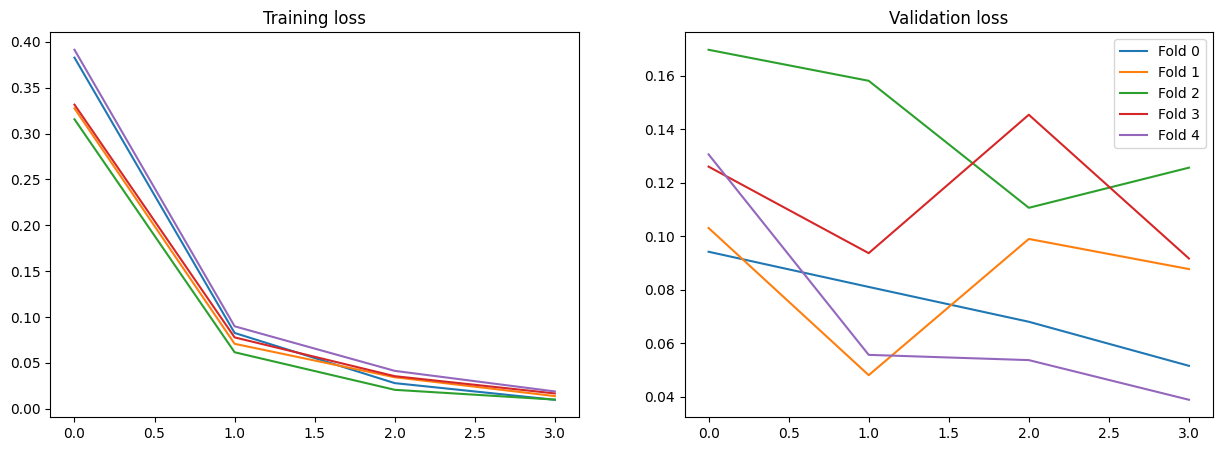

In [28]:
# Plot all fold training and validation losses
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.plot(cross_train_losses[i], label=f"Fold {i}")
    plt.title("Training loss")
    plt.subplot(1, 2, 2)
    plt.plot(cross_val_losses[i], label=f"Fold {i}")
    plt.title("Validation loss")
plt.legend()
plt.show()

The plots show the evolution of training loss (left) and validation loss (right) over the course of training across five folds.

1. Training Loss:

The training loss consistently decreases across all folds, indicating that the model is successfully learning from the data.
A sharp drop in loss occurs within the first epoch, after which the decline becomes more gradual.
The similarity in loss trends across folds suggests a stable learning process where the model continues refining its parametes while converging.

2. Validation Loss:

The validation loss behaves less uniformly across folds compared to the training loss.
Some folds exhibit a steady decrease (Fold 0 and Fold 4), indicating good generalization.
Other folds, such as Fold 2 and Fold 3, show fluctuations, suggesting potential overfitting or variations in the difficulty of different validation subsets.
The variance in validation loss among folds highlights the importance of cross-validation, as individual folds may present different challenges for the model.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
test_dataloader = DataLoader(
    tokenized_datasets["test"], shuffle=False, batch_size=8, collate_fn=data_collator
)

print("Train dataloader length:", len(train_dataloader))
print("Test dataloader length:", len(test_dataloader))

Train dataloader length: 252
Test dataloader length: 27


In [29]:
# Cross validation Mean F1 score
mean_f1_score = np.mean(cross_val_f1_scores)
print(f"Cross-Validation Mean Macro F1 Score: {mean_f1_score:.4f}")

Cross-Validation Mean Macro F1 Score: 0.9832


Moreover, we used the F1 score to evaluate the performance of our classification model. This metric balances two key aspects:

- Precision: How many of the predicted positive cases are actually correct.
- Recall: How many of the actual positive cases did the model successfully detect.

By combining these two elements into a single value, the F1 Score provides a measure of a model’s overall performance. The higher the F1 Score, the better the model’s performance, as it indicates both accuracy in predictions and success in detecting relevant cases.

In this context, the model obtained an F1 score of 0.9832 during training with 5-fold cross-validation, ensuring that its performance was consistently evaluated across multiple subsets of the data. This high score indicates that the model is excellent at making accurate decisions for the proposed classification task

---

## Test Evaluation

The following results reflect the performance of the document classifier on the test set. The model's performance is evaluated using precision, recall, f1-score, and accuracy metrics, as well as a confusion matrix.

In [30]:
# Load best model
model = AutoModelForSequenceClassification.from_pretrained(models_path + "fold_4")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [31]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_test.extend(torch.argmax(outputs.logits, dim=-1).tolist())
        y_true_test.extend(batch["labels"].tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)
print(y_pred_test.shape, y_true_test.shape)

print(classification_report(y_true_test, y_pred_test, target_names=class_names))

(210,) (210,)
               precision    recall  f1-score   support

     business       1.00      0.98      0.99        50
entertainment       1.00      1.00      1.00        30
     politics       0.98      1.00      0.99        40
       sports       1.00      1.00      1.00        50
         tech       1.00      1.00      1.00        40

     accuracy                           1.00       210
    macro avg       1.00      1.00      1.00       210
 weighted avg       1.00      1.00      1.00       210



As seen above, the model performs exceptionally well with minimal errors. The only misclassifications occurred between business and politics, which may suggest a minimal overlap or similarity between these two classes. Overall, the classifier demonstrates high accuracy and robustness across the dataset, obtaining almost perfect scores in all metrics.

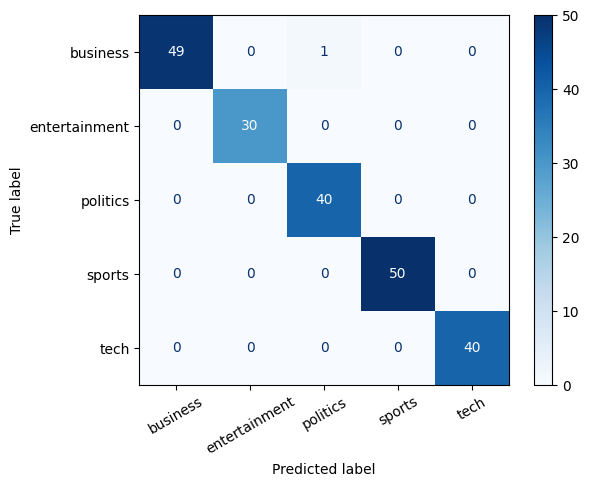

In [32]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_true_test, y_pred_test, display_labels=id2label.values(), xticks_rotation=30, cmap=plt.cm.Blues)

Regarding the confusion matrix, the results confirm the quantitative metrics. Only 1 missclassification occured, where a business documents was incorrectly labeled as politics. Nonetheless, no other confusion between categories is observed, indicating clear classification between boundaries.

In conclusion, the classifier performs with near-perfect accuracy, demosntrating its ability to distinguish between the five document categories effectively. The minor misclassification suggests that the model could benefit from slight improvements in distinguishing between business and politics, potentially by enhancing feature representations or adding more training examples to address subtle overlaps. However, the overall performance suggests the model is robust and reliable